# Deep Convolutional Generative Adversarial Network

This example builds DCGAN in Equinox, which is a Generative Adversarial Network (GAN) using convolutional layers in the discriminator and generator.

This example is an implementation based on the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

Reference:

```
@misc{radford2015unsupervised,
  author = {Radford, Alec and Metz, Luke and Chintala, Soumith},
  title = {Unsupervised Representation Learning with Deep Convolutional Generative
  Adversarial Networks},
  url = {http://arxiv.org/abs/1511.06434},
  year = 2015
}
```

In [1]:
# imports

import jax

import jax.numpy as jnp
import jax.random as jr

import optax

import torch
from typing import Union

import equinox as eqx

In [2]:
# Hyperparameters

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

batch_size = 32
epochs = 10

image_size = (64, 64, 1)
latent_size = 100

In [ ]:
# loading the MNIST dataset using torchvision

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((image_size[0], image_size[1])),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

data = torchvision.datasets.MNIST(root="./data", transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=True, num_workers=2
)

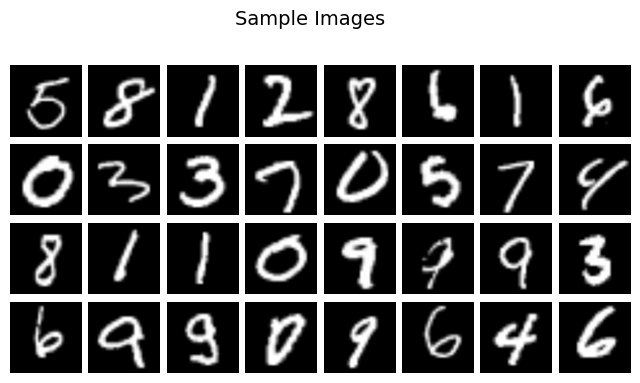

In [130]:
# plotting some training images

import matplotlib.pyplot as plt

images = next(iter(dataloader))

plot_sample = images[0].permute(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Sample Images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [5]:
# Generator Model


class Generator(eqx.Module):
    conv_layers: list[Union[eqx.nn.ConvTranspose2d, eqx.nn.BatchNorm, jax.nn.relu]]
    output_layers: list[Union[eqx.nn.ConvTranspose2d, jax.nn.tanh]]

    def __init__(
        self,
        input_shape: int = latent_size,
        output_shape: tuple[int, int] = image_size,
        key: jr.PRNGKey = jr.PRNGKey(2003),
    ):
        keys = jr.split(key, 5)

        self.conv_layers = [
            eqx.nn.ConvTranspose2d(
                in_channels=input_shape,
                out_channels=output_shape[0] * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                use_bias=False,
                key=keys[0],
            ),
            eqx.nn.BatchNorm(input_size=output_shape[0] * 8, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0] * 8,
                out_channels=output_shape[0] * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[1],
            ),
            eqx.nn.BatchNorm(input_size=output_shape[0] * 4, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0] * 4,
                out_channels=output_shape[0] * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[2],
            ),
            eqx.nn.BatchNorm(input_size=output_shape[0] * 2, axis_name="batch"),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0] * 2,
                out_channels=output_shape[0],
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[3],
            ),
            eqx.nn.BatchNorm(input_size=output_shape[0], axis_name="batch"),
            jax.nn.relu,
        ]

        self.output_layers = [
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0],
                out_channels=output_shape[2],
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[4],
            ),
            jax.nn.tanh,
        ]

    def __call__(self, x, state):
        for layer in self.conv_layers:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            else:
                x = layer(x)
        for layer in self.output_layers:
            x = layer(x)

        return x, state

In [6]:
# Discriminator Model


class Discriminator(eqx.Module):
    input_layers: list[Union[eqx.nn.Conv2d, eqx.nn.PReLU]]
    hidden_layers: list[Union[eqx.nn.Conv2d, eqx.nn.BatchNorm, eqx.nn.PReLU]]
    output_layers: list[Union[eqx.nn.Conv2d, jax.nn.sigmoid]]

    def __init__(
        self,
        input_shape: tuple[int, int, int] = image_size,
        key: jr.PRNGKey = jr.PRNGKey(2003),
    ):
        keys = jr.split(key, 5)

        self.input_layers = [
            eqx.nn.Conv2d(
                in_channels=input_shape[2],
                out_channels=input_shape[1],
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[0],
            ),
            eqx.nn.PReLU(0.2),
        ]

        self.hidden_layers = [
            eqx.nn.Conv2d(
                in_channels=input_shape[1],
                out_channels=input_shape[1] * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[1],
            ),
            eqx.nn.BatchNorm(input_shape[1] * 2, axis_name="batch"),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=input_shape[1] * 2,
                out_channels=input_shape[1] * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[2],
            ),
            eqx.nn.BatchNorm(input_shape[1] * 4, axis_name="batch"),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=input_shape[1] * 4,
                out_channels=input_shape[1] * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                use_bias=False,
                key=keys[3],
            ),
            eqx.nn.BatchNorm(input_shape[1] * 8, axis_name="batch"),
            eqx.nn.PReLU(0.2),
        ]

        self.output_layers = [
            eqx.nn.Conv2d(
                in_channels=input_shape[1] * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                use_bias=False,
                key=keys[4],
            ),
        ]

    def __call__(self, x, state):
        for layer in self.input_layers:
            x = layer(x)

        for layer in self.hidden_layers:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state=state)
            else:
                x = layer(x)

        for layer in self.output_layers:
            x = layer(x)

        return x, state

In [7]:
# Adding the BCE loss function and the optimizers


@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_discriminator(
    discriminator,
    generator,
    fake_labels,
    real_batch,
    real_labels,
    discriminator_state,
    generator_state,
    key,
):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size, 1, 1))

    fake_batch, generator_state = jax.vmap(
        generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(
        discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(fake_batch, discriminator_state)
    loss1 = optax.sigmoid_binary_cross_entropy(pred_y, fake_labels).mean()

    pred_y, discriminator_state = jax.vmap(
        discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(real_batch, discriminator_state)
    loss2 = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    loss = (loss1 + loss2) / 2

    return loss, (discriminator_state, generator_state, key)


@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_generator(
    generator, discriminator, real_labels, discriminator_state, generator_state, key
):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size, 1, 1))

    fake_batch, generator_state = jax.vmap(
        generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(
        discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None)
    )(fake_batch, discriminator_state)
    loss = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    return loss, (discriminator_state, generator_state, key)

In [8]:
@eqx.filter_jit
def step_discriminator(
    discriminator: Discriminator,
    generator: Generator,
    real_batch: jnp.ndarray,
    real_labels: jnp.ndarray,
    fake_labels: jnp.ndarray,
    discriminator_optimizer: optax.GradientTransformation,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    key: jr.PRNGKey,
):
    (
        loss,
        (discriminator_state, generator_state, key),
    ), grads = compute_grads_discriminator(
        discriminator,
        generator,
        fake_labels,
        real_batch,
        real_labels,
        discriminator_state,
        generator_state,
        key,
    )

    updates, opt_state = discriminator_optimizer.update(
        grads, discriminator_opt_state, discriminator
    )
    discriminator = eqx.apply_updates(discriminator, updates)

    return loss, discriminator, opt_state, generator_state, discriminator_state, key


@eqx.filter_jit
def step_generator(
    generator: Generator,
    discriminator: Discriminator,
    real_labels: jnp.ndarray,
    generator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_state: eqx.nn.State,
    generator_state: eqx.nn.State,
    key: jr.PRNGKey,
):
    (
        loss,
        (discriminator_state, generator_state, key),
    ), grads = compute_grads_generator(
        generator, discriminator, real_labels, discriminator_state, generator_state, key
    )

    updates, opt_state = generator_optimizer.update(grads, generator_opt_state)
    generator = eqx.apply_updates(generator, updates)

    return loss, generator, opt_state, discriminator_state, generator_state, key

In [9]:
# Training both the generator and the discriminator


def train(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    discriminator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    data_loader: torch.utils.data.DataLoader,
    epochs: int,
    key: jr.PRNGKey,
):
    for step in range(epochs):
        batch_num = 0
        for batch in data_loader:
            batch_num += 1

            (
                discriminator_loss,
                discriminator,
                discriminator_opt_state,
                generator_state,
                discriminator_state,
                key,
            ) = step_discriminator(
                discriminator,
                generator,
                batch[0].numpy(),
                real_labels,
                fake_labels,
                discriminator_optimizer,
                discriminator_opt_state,
                generator_state,
                discriminator_state,
                key,
            )

            (
                generator_loss,
                generator,
                generator_opt_state,
                discriminator_state,
                generator_state,
                key,
            ) = step_generator(
                generator,
                discriminator,
                real_labels,
                generator_optimizer,
                generator_opt_state,
                discriminator_state,
                generator_state,
                key,
            )

            generator_losses.append(generator_loss)
            discriminator_losses.append(discriminator_loss)

        print(
            f"Epoch: {step+1}/{epochs}, Generator loss: {generator_loss}, "
            f"Discriminator loss: {discriminator_loss}"
        )

    return generator, discriminator, generator_state, discriminator_state, key

In [10]:
key = jr.PRNGKey(2003)

key, gen_key, disc_key = jr.split(key, 3)

generator = Generator(key=gen_key)
discriminator = Discriminator(key=disc_key)

generator_state = eqx.nn.State(generator)
discriminator_state = eqx.nn.State(discriminator)

generator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)
discriminator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)

generator_opt_state = generator_optimizer.init(eqx.filter(generator, eqx.is_array))
discriminator_opt_state = discriminator_optimizer.init(
    eqx.filter(discriminator, eqx.is_array)
)

real_labels = jnp.ones(batch_size)
fake_labels = jnp.zeros(batch_size)

generator_losses = []
discriminator_losses = []

In [13]:
generator, discriminator, generator_state, discriminator_state, key = train(
    generator,
    discriminator,
    generator_optimizer,
    discriminator_optimizer,
    generator_opt_state,
    discriminator_opt_state,
    generator_state,
    discriminator_state,
    dataloader,
    epochs,
    key,
)

Epoch: 1/5, Generator loss: 3.1651129722595215, Discriminator loss: 0.2802504897117615
Epoch: 2/5, Generator loss: 0.6975896954536438, Discriminator loss: 0.28889214992523193
Epoch: 3/5, Generator loss: 2.7292776107788086, Discriminator loss: 0.3007465600967407
Epoch: 4/5, Generator loss: 2.133923292160034, Discriminator loss: 0.5363401174545288
Epoch: 5/5, Generator loss: 1.8741599321365356, Discriminator loss: 0.4067755341529846


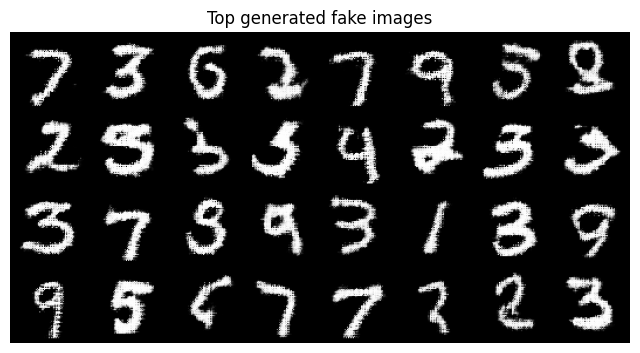

In [34]:
# Doing inference to test the model

key, subkey = jr.split(key)
noise = jr.normal(subkey, (1000, latent_size, 1, 1))


@eqx.filter_jit
def evaluate(model, xx):
    out, _ = jax.vmap(model)(xx)
    return out


inference_gen = eqx.tree_inference(generator, value=True)
inference_gen = eqx.Partial(inference_gen, state=generator_state)

generated_images = evaluate(inference_gen, noise)

inference_discriminator = eqx.tree_inference(discriminator, value=True)
inference_discriminator = eqx.Partial(
    inference_discriminator, state=discriminator_state
)

logits = evaluate(inference_discriminator, generated_images)

plot_sample = generated_images[
    jax.lax.top_k(jax.nn.sigmoid(logits).squeeze(), 32)[1]
].transpose(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Top generated fake images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()